# Bird Classifier using Transfer Learning from MobileNetv2

## Notebook Abstract:

This model is a demonstration on using Transfer Learning to build an accurate model quickly.

It will build a model by loading in the dataset and performing image augmentation, running it through the MobileNetV2 model without the top, and using 4 ending dense layers to output a 450 class softmax for each species of bird in the dataset.

The training will be done in 3 rounds of fitting:
* Each round will run for 10 epochs.
* Each round will subsequently increase the number of trainable layers at the end of the Mobile Net base model.
* Each round will shrink the learning rate by a scaling factor.

Lets start!

<img src="https://i.pinimg.com/originals/0c/6a/f2/0c6af2ed796422de38d7467cff88bf43.gif" width="400" align="center">

In [28]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## Set Hyperparameters

In [5]:
FILEPATH = '../input/100-bird-species/' # filepath for data
BATCH_SIZE = 64 # keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)

ROUND_1_TRAINABLE_LAYERS = 38 # layers at end of the mobile_net base model to have trainable parameters
ROUND_1_EPOCHS = 5

LEARNING_RATE = 0.0001

MODEL_CHECKPOINT_FILEPATH = './Bird-Classifier-Model-Checkpoint.ckpt'

SEED = 6278 # random seed for repeatability of notebook

## Load Datasets with *image_dataset_from_directory*

In [6]:
# Training Dataset
train = image_dataset_from_directory(directory = FILEPATH + 'train/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Validation Dataset
valid = image_dataset_from_directory(directory = FILEPATH + 'valid/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Test Dataset
test = image_dataset_from_directory(directory = FILEPATH + 'test/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

Found 70626 files belonging to 450 classes.


2022-12-19 08:28:42.090505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 08:28:42.261733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 08:28:42.262683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 08:28:42.264801: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2250 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.


## Visualize Data Samples

2022-12-19 08:29:04.212938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


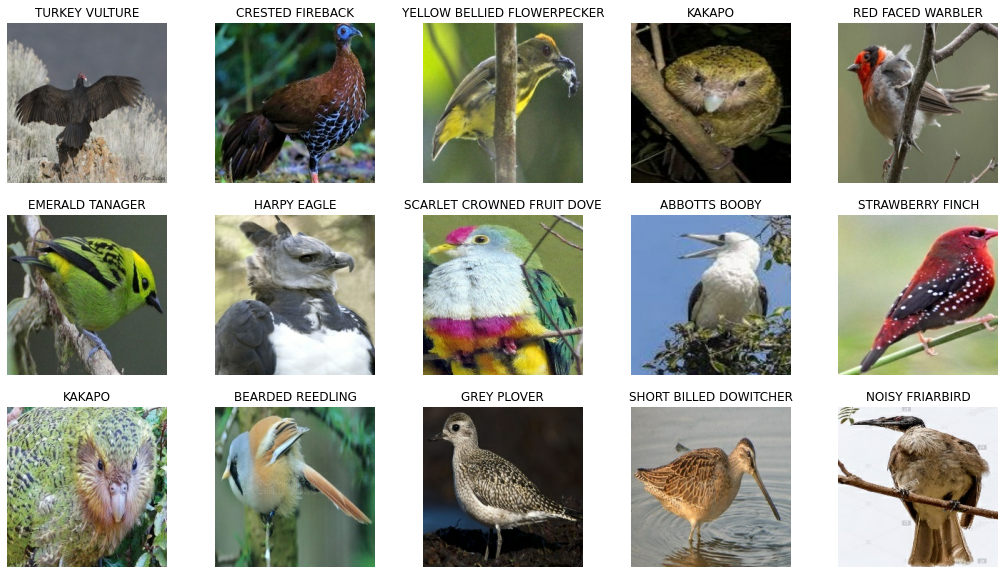

In [7]:
class_names = train.class_names

plt.figure(figsize=(18, 10))

for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Data Augmentation

In [8]:
def data_augmentor(h_flip=True, v_flip=False, rotate=True,):
    
    augmentor = Sequential() # Create returned Sequential class.
    augmentor.add(layers.Rescaling(1./255)) # Rescale image values from 0 - 255 to 0 - 1.

    # Based on function arguments: perform random flipping
    if h_flip and v_flip:
        augmentor.add(layers.RandomFlip('horizontal_and_vertical'))
    elif h_flip:
        augmentor.add(layers.RandomFlip('horizontal'))
    elif v_flip:
        augmentor.add(layers.RandomFlip('vertical'))

    # Based on function arguments: perform random rotation    
    if rotate:
        augmentor.add(layers.RandomRotation(0.2))
    
    return augmentor

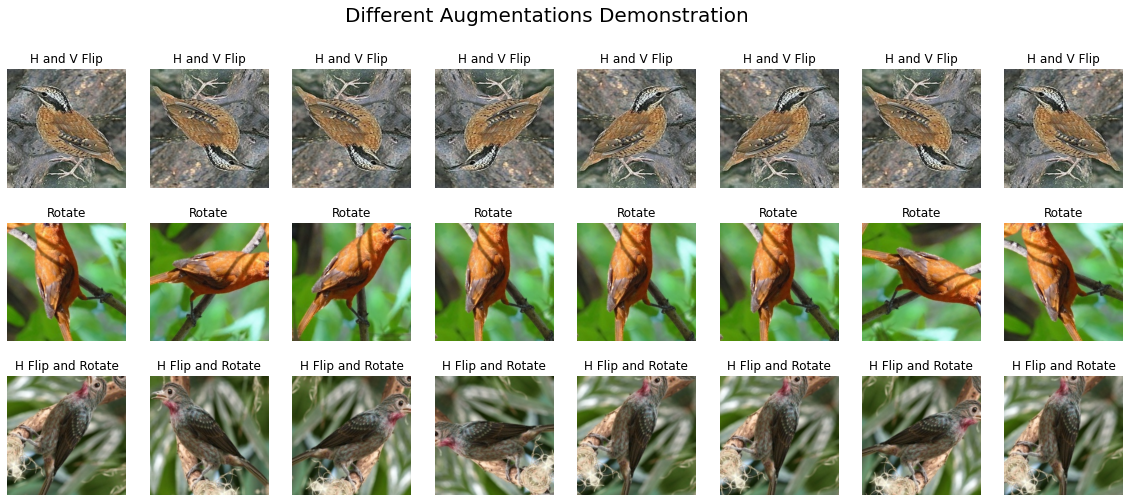

In [9]:
augmentor1 = data_augmentor(h_flip = True, v_flip = True, rotate=False)
augmentor2 = data_augmentor(h_flip = False, v_flip = False, rotate=True)
augmentor3 = data_augmentor(h_flip = True, v_flip = False, rotate=True)

augs = [augmentor1, augmentor2, augmentor3]

details = ['H and V Flip',
           'Rotate',
           'H Flip and Rotate']

plt.figure(figsize=(20, 8))
for images, labels in train.take(1):
    for i, aug in enumerate(augs):
        img = images[i]
        for j in range(8):
            ax = plt.subplot(3, 8, (i*8 + j + 1))
            img_augmented = aug(tf.expand_dims(img, 0))
            plt.imshow(img_augmented[0])
            plt.axis('off')
            ax.set_title(details[i])
            
plt.suptitle('Different Augmentations Demonstration', fontsize=20);

# Import MobileNetV2 Base Model

In [10]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

mobile_base = MobileNetV2(input_shape = IMAGE_SHAPE,
                          include_top = False,
                          weights = 'imagenet')

mn_layers = len(mobile_base.layers)

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
mobile_base.trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!\n'.format(ROUND_1_TRAINABLE_LAYERS))

for mn_layer in mobile_base.layers[:-ROUND_1_TRAINABLE_LAYERS]:
    mn_layer.trainable = False
    
trainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in mobile_base.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('The number of trainable parameters in the Mobile Net V2 Base Model is {}.'.format(trainableParams))
print('The number of non-trainable parameters in the Mobile Net V2 Base Model is {}.'.format(nonTrainableParams))
print('The total number of parameters is {}.'.format(totalParams))

Setting the last 38 layers in the Mobile Net Base Model to trainable!

The number of trainable parameters in the Mobile Net V2 Base Model is 1681344.
The number of non-trainable parameters in the Mobile Net V2 Base Model is 576640.
The total number of parameters is 2257984.


# Build Model
## Augmentor &rarr; Mobile Net V2 Base &rarr; 3 Dense Layers resulting in Softmax Output

In [12]:
# start model with input shape equal to image shape
inputs = tf.keras.Input(shape = IMAGE_SHAPE)
# apply h-flip and rotation data augmentation
x = augmentor3(inputs)
# apply through mobile net v2 base
x = mobile_base(x)
# global average pool to collapse to 1D
x = layers.GlobalAveragePooling2D()(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected layer with 2000
x = layers.Dense(1500)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(1200)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(900)(x) 
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
outputs = layers.Dense(450, activation='softmax')(x) 
        
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
re_lu (ReLU)                 (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

# Train Model

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
#optimizer = tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE,momentum=0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

callbacks = [model_checkpoint,early_stopping]

model.compile(optimizer = optimizer,
              loss = loss,
              metrics=['accuracy'])

In [17]:
history = model.fit(train, 
                    validation_data=valid, 
                    epochs=ROUND_1_EPOCHS, 
                    callbacks = callbacks)

Epoch 1/5


2022-12-19 08:30:30.262088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1104/1104 [==============================] - 247s 213ms/step - loss: 4.5744 - accuracy: 0.1757 - val_loss: 2.2256 - val_accuracy: 0.5347

Epoch 00001: val_accuracy improved from -inf to 0.53467, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 2/5
1104/1104 [==============================] - 123s 111ms/step - loss: 2.0275 - accuracy: 0.5616 - val_loss: 0.8764 - val_accuracy: 0.7924

Epoch 00002: val_accuracy improved from 0.53467 to 0.79244, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 3/5
1104/1104 [==============================] - 119s 107ms/step - loss: 1.2044 - accuracy: 0.7156 - val_loss: 0.5167 - val_accuracy: 0.8729

Epoch 00003: val_accuracy improved from 0.79244 to 0.87289, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 4/5
1104/1104 [==============================] - 124s 111ms/step - loss: 0.8649 - accuracy: 0.7851 - val_loss: 0.4039 - val_accuracy: 0.8956

Epoch 00004: val_accuracy improved from 0.87289 to 0.89556, saving model 

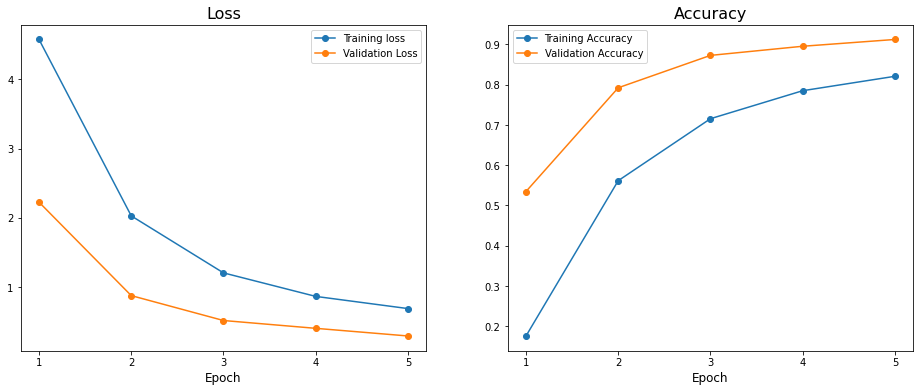

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = ROUND_1_EPOCHS

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

# Evaluate Model Accuracy on Test Data

In [44]:
model = load_model('/kaggle/working/Bird-Classifier-Model-Checkpoint.ckpt/saved_model.pb')

NameError: name 'load_model' is not defined

In [19]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH)

test_loss, test_accuracy = model.evaluate(test)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

36/36 [==============================] - 9s 183ms/step - loss: 0.2704 - accuracy: 0.9280

The model had an accuracy score of 92.8%!!


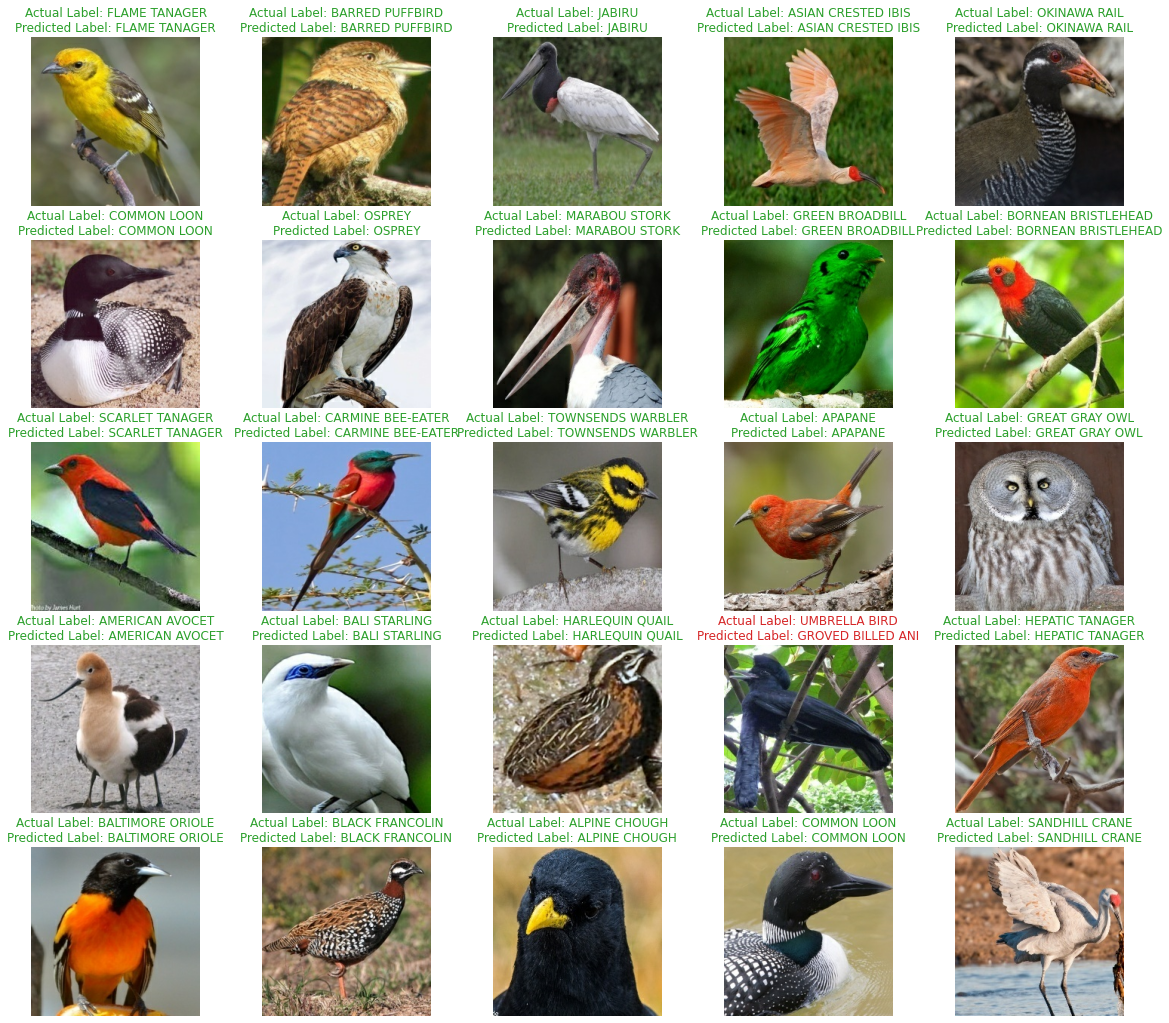

In [20]:
plt.figure(figsize=(20, 18))

for images, labels in test.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")

# Predict radom image

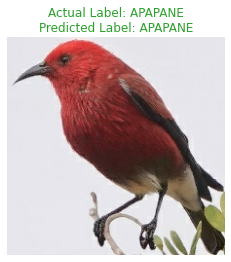

In [21]:
#plt.figure(figsize=(20, 18))

k = random.randint (1, len(test))

for images, labels in test.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(1):
        ax = plt.subplot(1, 1, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")

In [22]:
CLASSES = len (class_names)
print(CLASSES)

450


In [23]:
directory = FILEPATH + 'test/'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [24]:
test_generator = test_datagen.flow_from_directory(
            directory,
            target_size=(224,224),
            batch_size=1,
            class_mode='categorical',
            shuffle=False
          )

Found 2250 images belonging to 450 classes.


In [25]:
img_test = []
for i in sorted (os.listdir(directory)):
  bird = os.path.join(directory, i)
  for j in sorted(os.listdir(bird)):
    img_test.append (os.path.join(bird, j))

In [26]:
true_labels = []
pred_labels = []
for k in range (len(test_generator)):
  images = img_test[k]
  true_label = np.argmax(test_generator[k][1])
  pred_label = np.argmax (model.predict (test_generator[k][0]))
  true_labels.append (true_label)
  pred_labels.append (pred_label)

In [29]:
precision = precision_score(true_labels, pred_labels, average='macro')
precision

0.9414038800705468

In [30]:
recall = recall_score(true_labels, pred_labels, average='macro')
recall

0.9257777777777778

In [45]:
print ('Accuracy', accuracy_score(true_labels, pred_labels))
print ('F1-score:', precision_score(true_labels, pred_labels, average='macro'))

Accuracy 0.9257777777777778
F1-score: 0.9414038800705468


In [89]:
def precision(matrix, n):
    avg_precise = 0
    for i in range(n):
        tp = matrix[i][i]
        pred = np.sum(matrix[:, i])
        if (pred != 0):
            avg_precise += tp / pred

    return avg_precise / n


def recall(matrix, n):
    avg_recall = 0
    for i in range(n):
        tp = matrix[i][i]
        true = np.sum(matrix[i,:])
        avg_recall += tp / true

    return avg_recall / n


def f1_score(precision, recall):
    return (2 * precision * recall) / (precision + recall)

In [50]:
from sklearn import metrics

In [83]:
confusion_matrix = metrics.confusion_matrix(true_labels, pred_labels)

In [84]:
confusion_matrix

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 4]])

In [60]:
r = recall(confusion_matrix,450)

In [64]:
r

0.9257777777777789

In [90]:
p = precision(confusion_matrix,450)

In [91]:
p

0.9414038800705463

In [92]:
print(f1_score(p, r))

0.9335254429260093


In [87]:
def accuracy (y_true, y_pred):
  sum = 0
  n = len(y_true)
  for i in range (n):
    sum+=int (y_true[i]==y_pred[i])
  return sum/n

In [88]:
accuracy (true_labels, pred_labels)

0.9257777777777778

In [33]:
train_dir = FILEPATH + 'train/'
class_name = sorted (os.listdir(train_dir))

In [34]:
dict_bird_name = {}
for i in range (CLASSES):
  dict_bird_name[i] = class_name[i]

In [36]:
target_names = list (dict_bird_name.values())
print(classification_report(true_labels, pred_labels, target_names=target_names))

                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      1.00      1.00         5
                ABBOTTS BOOBY       1.00      0.40      0.57         5
   ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      0.60      0.75         5
                    ALBATROSS       0.83      1.00      0.91         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
                ALPINE CHOUGH       1.00      1.00      1.00         5
        ALTAMIRA YELLOWTHROAT       1.00      0.60      0.75         5
     

In [35]:
for i in range(CLASSES):
    score_sum = 0
    for j in range(5):
        score_sum += int(true_labels[i*5+j] == pred_labels[i*5+j])
    if score_sum == 5:
        print('\033[92m' + '{}: {} / 5'.format(dict_bird_name[i], score_sum))
    else:
        print('\033[91m' + '{}: {} / 5'.format(dict_bird_name[i], score_sum))

ABBOTTS BABBLER: 5 / 5
ABBOTTS BOOBY: 2 / 5
ABYSSINIAN GROUND HORNBILL: 5 / 5
AFRICAN CROWNED CRANE: 5 / 5
AFRICAN EMERALD CUCKOO: 5 / 5
AFRICAN FIREFINCH: 5 / 5
AFRICAN OYSTER CATCHER: 5 / 5
AFRICAN PIED HORNBILL: 3 / 5
ALBATROSS: 5 / 5
ALBERTS TOWHEE: 5 / 5
ALEXANDRINE PARAKEET: 5 / 5
ALPINE CHOUGH: 5 / 5
ALTAMIRA YELLOWTHROAT: 3 / 5
AMERICAN AVOCET: 5 / 5
AMERICAN BITTERN: 5 / 5
AMERICAN COOT: 5 / 5
AMERICAN FLAMINGO: 5 / 5
AMERICAN GOLDFINCH: 5 / 5
AMERICAN KESTREL: 5 / 5
AMERICAN PIPIT: 5 / 5
AMERICAN REDSTART: 4 / 5
AMERICAN WIGEON: 5 / 5
AMETHYST WOODSTAR: 4 / 5
ANDEAN GOOSE: 5 / 5
ANDEAN LAPWING: 5 / 5
ANDEAN SISKIN: 5 / 5
ANHINGA: 5 / 5
ANIANIAU: 4 / 5
ANNAS HUMMINGBIRD: 5 / 5
ANTBIRD: 5 / 5
ANTILLEAN EUPHONIA: 3 / 5
APAPANE: 5 / 5
APOSTLEBIRD: 5 / 5
ARARIPE MANAKIN: 5 / 5
ASHY STORM PETREL: 1 / 5
ASHY THRUSHBIRD: 5 / 5
ASIAN CRESTED IBIS: 5 / 5
ASIAN DOLLARD BIRD: 5 / 5
AUCKLAND SHAQ: 2 / 5
AUSTRAL CANASTERO: 3 / 5
AUSTRALASIAN FIGBIRD: 5 / 5
AVADAVAT: 3 / 5
AZARAS SPINETAIL: